### SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os


filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess data

In [ ]:
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filenames[1])

In [ ]:
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
len(train_lines)

35135

In [ ]:
a = 'kranthi kumar'
a.startswith("kumar")

False

In [ ]:
def preprocess_text_with_line_numbers(filename):

  """
  Returns a list of dictionay

  {'target' : label,
   'text' : text,
   'total_lines' : number of lines in each abstract

  }

  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []


  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check for a new line /n
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionaly for each line
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) -1 #starting from 0

        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
filenames[1]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])
val_samples = preprocess_text_with_line_numbers(filenames[2])

print(len(train_samples), len(test_samples), len(val_samples))

180040 30135 30212
CPU times: user 398 ms, sys: 81.3 ms, total: 479 ms
Wall time: 475 ms


Importing Libraries

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-10 11:37:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-10 11:37:31 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import helper_functions as hf

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
val_df[:14]

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
5,RESULTS,sixty-five patients were randomized .,5,9
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <a list of 10 Patch objects>)

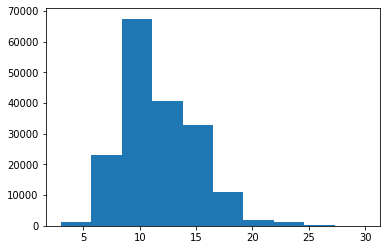

In [ ]:
plt.hist(train_df['total_lines'])

### Make numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

train_labels_one_hot = ohe.fit_transform(train_df[['target']])
val_labels_one_hot = ohe.transform(val_df[['target']])
test_labels_one_hot = ohe.transform(test_df[['target']])

In [ ]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Model 1 :Building a Base line Naive Bayes Machine Learning model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


model_0 = Pipeline([('tfidf' , TfidfVectorizer()), ('clf' , MultinomialNB())]) 

model_0.fit(X= train_df['text'], y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_df['text'], y = val_labels_encoded)

0.7218323844829869

In [ ]:
base_line_pred = model_0.predict(val_df['text'])

In [ ]:
hf.calculate_results(y_true = val_labels_encoded, y_pred = base_line_pred)

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preprocessing data for deep sequence

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
print(max(sent_lens))
print(min(sent_lens))
print(np.mean(sent_lens))

296
1
26.338269273494777


(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

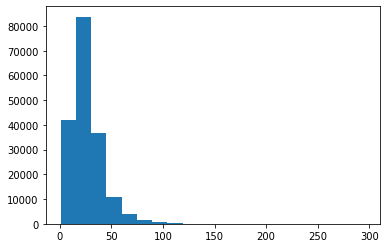

In [ ]:
plt.hist(sent_lens, bins=20)

In [ ]:
np.percentile(sent_lens,95)

55.0

In [ ]:
max_tokens = 68000 #given in paper


### Creating a Text Vectorizer

Text Vectorizer well get the corpus of all unique words and assign a label to each word

In [ ]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = max_tokens,
                                                                               output_sequence_length = 55) #desired output length of vectorized sequences

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
len(text_vectorizer.get_vocabulary())

64841

In [ ]:
text_vectorizer.get_config()

{'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Creating an Embedded layer

In [ ]:
token_embed = tf.keras.layers.Embedding(input_dim = len(text_vectorizer.get_vocabulary()),
                                           output_dim  = 128,
                                           mask_zero = True, #helps tensorflow to do efficient computing when there are lot of zeros
                                           name = 'token_embedding'
                                           )

In [ ]:
vectorized_sentence = text_vectorizer([random_sentence])
embedded_sentence = token_embed(vectorized_sentence)
print(vectorized_sentence, vectorized_sentence.shape)
print(embedded_sentence, embedded_sentence.shape)


#55 each of 128

tf.Tensor(
[[1081    2  984    4  489 8253    2   47  448  101 1555    4  489  149
   128 1049  200    4  678  107 2198 4818    3 1049  200    4 2581 3947
  4477    9   62 2457  170   21   19   25   34    7  125  129   19    5
   122   13   62   14    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64) (1, 55)
tf.Tensor(
[[[ 0.01627118 -0.02450452  0.04984579 ...  0.03905488  0.029134
   -0.00302225]
  [-0.00362798 -0.0395328  -0.04002911 ... -0.01375794  0.02687541
    0.04030791]
  [ 0.00863228 -0.01642345 -0.00914203 ... -0.01194929 -0.02754265
   -0.04791982]
  ...
  [ 0.0023425   0.0166187  -0.04497978 ... -0.02904201  0.04468176
   -0.01798243]
  [ 0.0023425   0.0166187  -0.04497978 ... -0.02904201  0.04468176
   -0.01798243]
  [ 0.0023425   0.0166187  -0.04497978 ... -0.02904201  0.04468176
   -0.01798243]]], shape=(1, 55, 128), dtype=float32) (1, 55, 128)


### Creating Tensorfow Datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1 : 1D convolutional model

In [ ]:
len(train_dataset)

5627

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) # only validate on 10% of batches


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6035 - accuracy: 0.7844


[0.6035189628601074, 0.7843903303146362]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[4.43518221e-01, 1.66523248e-01, 8.04400966e-02, 2.84424692e-01,
        2.50937548e-02],
       [4.30512130e-01, 2.94177234e-01, 1.16284396e-02, 2.57881343e-01,
        5.80080552e-03],
       [1.62805155e-01, 1.31346369e-02, 2.55340477e-03, 8.21475565e-01,
        3.12877310e-05],
       ...,
       [4.30447699e-06, 8.01354239e-04, 8.98547238e-04, 2.23100892e-06,
        9.98293579e-01],
       [5.14281690e-02, 4.99617338e-01, 9.46133137e-02, 6.18591122e-02,
        2.92482108e-01],
       [1.99014604e-01, 5.70368707e-01, 4.64562736e-02, 6.98785707e-02,
        1.14281826e-01]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = hf.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4390308486694,
 'f1': 0.7819437563119045,
 'precision': 0.7809284366878455,
 'recall': 0.784390308486694}

### Feature extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = tf.keras.layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9152 - accuracy: 0.6521 - val_loss: 0.7966 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7698 - accuracy: 0.7013 - val_loss: 0.7562 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7543 - accuracy: 0.7109 - val_loss: 0.7408 - val_accuracy: 0.7108


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7436 - accuracy: 0.7129


[0.7436054348945618, 0.7129286527633667]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[0.43398887, 0.36684963, 0.00259   , 0.1898782 , 0.00669336],
       [0.32287553, 0.53331137, 0.00433346, 0.13666655, 0.00281311],
       [0.22638303, 0.13279772, 0.01792587, 0.5846048 , 0.03828866],
       ...,
       [0.00210372, 0.00618837, 0.06679914, 0.00094522, 0.92396355],
       [0.00395043, 0.04613357, 0.20530653, 0.00155678, 0.7430527 ],
       [0.151448  , 0.27094862, 0.5103774 , 0.00735769, 0.05986826]],
      dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>